In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import preprocess, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler
from hython.metrics import RMSELoss

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset


from hython.utils import missing_location_idx, reconstruct_from_missing

from hython.models.lstm import CustomLSTM
# viz
import matplotlib.pyplot as plt
#import hvplot.xarray 
from hython.viz import plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(2023)

/home/iacopo/.local/build/mambaforge/envs/dl-pytorch/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/iacopo/.local/build/mambaforge/envs/dl-pytorch/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Intro

# Preprocessing

# Training

# Inference

# Intro


The surrogate's goal is to emulate the [wflow hydrological model](https://deltares.github.io/Wflow.jl/stable/) outputs,in particular:

- Soil moisture
- Actual evapotranspiration
- River discharge

This notebook shows the 

# Configuration

Ideally this would be managed by something like MLFlow? 

The configuration should describe the **experiment**. We are planning to run many experiments

In [4]:

wd = Path("../data/datademo")
fp_dynamic_forcings = wd / "forcings.nc"
fp_wflow_static_params = wd / "staticmaps.nc"
fp_target = wd / "output.nc"


dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc"] #, "actevap" ]


timeslice = slice("2016-01-01","2020-12-31")


### HYPERPARAMETERS

# training 

spatial_batch_size = 128*2
temporal_sampling_size = 200
seq_length = 365

# model 

hidden_size = 128

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing

Wflow runs on a gridded domain, discretized in time and space. The temporal resolution is 1 day and the spatial resolution is 1 km. The data temporal range that can be used for training and test is from 2007 to 2020.

The wflow input/output data structure has 4 dimensions: lat, lon, time, feature.  

The LSTM models works with a different structure: gridcell, time, feature. Therefore there is a need for reshaping the data back and forth for training and the visualization of the inference results on a map.

In [5]:
forcings = xr.open_dataset( fp_dynamic_forcings).rename({"latitude":"lat", "longitude":"lon"})
params = xr.open_dataset(fp_wflow_static_params ).rename({"latitude":"lat", "longitude":"lon"})
targets = xr.open_dataset(fp_target).isel(lat=slice(None, None, -1))

In [6]:
if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [7]:
#params.wflow_dem.hvplot(geo=True, tiles=True, cmap = "terrain").opts(width = 799, height= 600)

### Define data mask 

In [8]:
mask_lakes = (targets.mean(dim = "time")["actevap"] == 0).astype(np.bool_)

### Sampling (optional) & Reshaping

In [9]:
intervals = (10, 10)
train_origin = (0, 0)
valid_origin =  (5, 5)

In [10]:
Xd, Xs, Y, dims, meta = preprocess(forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names, 
                   sampler = RegularIntervalSampler(
                                 intervals = intervals,
                                 origin = train_origin
                    )
                   )
Xd_valid, Xs_valid, Y_valid, dims_valid, meta_valid = preprocess(
                    forcings, 
                   params, 
                   targets,
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names, 
                   sampler = RegularIntervalSampler(
                        intervals = intervals,
                        origin = valid_origin),
                   )

sampling reduced dims (lat, lon): from  [44, 33]  to  [5, 4]
dynamic:  (20, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (20, 8)  => (GRIDCELL, FEATURE)
target:  (20, 1827, 1)  => (GRIDCELL, TIME, TARGET)
sampling reduced dims (lat, lon): from  [44, 33]  to  [4, 3]
dynamic:  (12, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (12, 8)  => (GRIDCELL, FEATURE)
target:  (12, 1827, 1)  => (GRIDCELL, TIME, TARGET)


(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'spatial_ref = 0'}, xlabel='longitude coordinate\n[degrees_east]', ylabel='latitude coordinate\n[degrees_north]'>)

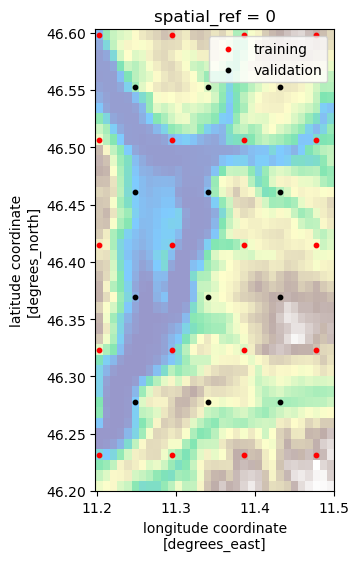

In [11]:
plot_sampler(params.wflow_dem, meta, meta_valid)

### Remove missing


In [12]:
# find indices of missing values
idx = missing_location_idx(Xs)
idx_valid = missing_location_idx(Xs_valid)

Xd_clean = Xd[~idx]
Xs_clean = Xs[~idx]
Y_clean = Y[~idx]
Xd_valid_clean = Xd_valid[~idx_valid]
Xs_valid_clean = Xs_valid[~idx_valid]
Y_valid_clean = Y_valid[~idx_valid]

### Normalization

In [13]:
Xd_clean, d_m, d_std = apply_normalization(Xd_clean, type = "spacetime", how ='standard')
Xs_clean, s_m, s_std = apply_normalization(Xs_clean, type = "space", how ='standard')

#Y_clean, y_m, y_std = apply_normalization(Y_clean, type = "spacetime", how ='standard')

Xd_valid_clean = apply_normalization(Xd_valid_clean, type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
Xs_valid_clean = apply_normalization(Xs_valid_clean, type = "space", how ='standard', m1 = s_m, m2 = s_std)

In [14]:

# to tensor

Xs_clean = torch.Tensor(Xs_clean)
Xd_clean = torch.Tensor(Xd_clean)
Y_clean = torch.Tensor(Y_clean)

Xs_valid_clean = torch.Tensor(Xs_valid_clean)
Xd_valid_clean = torch.Tensor(Xd_valid_clean)

Y_valid_clean = torch.Tensor(Y_valid_clean)

In [15]:
# data loader

train_dataset = LSTMDataset(Xd_clean, Y_clean, Xs_clean)
val_dataset = LSTMDataset(Xd_valid_clean, Y_valid_clean, Xs_valid_clean)

train_loader = DataLoader(train_dataset, batch_size=spatial_batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=spatial_batch_size, shuffle=False)

In [16]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=128, bias=True)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:

def mse_metric(output, target):
    metric_epoch = mean_squared_error(output, target, squared=True)
    return metric_epoch

# Training and validation 
path2models= "./checkpoints" #./output/kaggle/working/AI4EO/models
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
## Where to save the trained models weights 
## Set the optimization algorithms and learning rate
opt = optim.Adam(model.parameters(), lr=1e-2)

## Set the loss function
loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric #nn.MSELoss()

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 2

## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device

}

# Training

In [18]:
model, sm_loss_history ,sm_metric_history = train_val(model, params_train)

Epoch 0/1, current lr=0.01
Copied best model weights!
train loss: 0.004140298813581467, train metric: 0.004140298347920179
val loss: 0.0022958358749747276, val metric: 0.0022958358749747276
----------
Epoch 1/1, current lr=0.01
train loss: 0.001063680392690003, train metric: 0.0010636806255206466
val loss: 0.0027363551780581474, val metric: 0.002736355410888791
----------


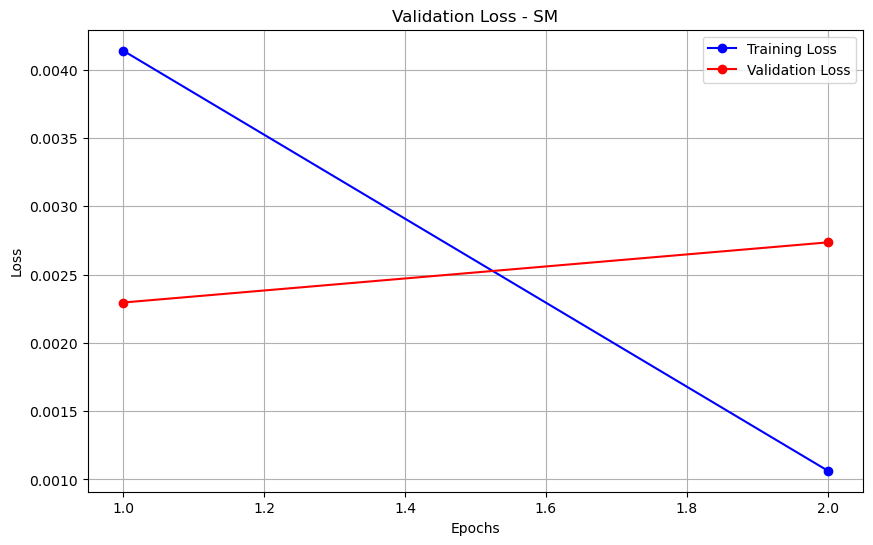

In [19]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train']
val_loss = sm_metric_history['val']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Inference

In [20]:
Xd1, Xs1, Y1, dims1, meta1 = preprocess(forcings, 
                   params, 
                   targets, 
                   dynamic_name = dynamic_names,
                   static_name = static_names, 
                   target_name = target_names
                   )

idx = missing_location_idx(Xs)

dynamic:  (1452, 1827, 3)  => (GRIDCELL, TIME, FEATURE)
static:  (1452, 8)  => (GRIDCELL, FEATURE)
target:  (1452, 1827, 1)  => (GRIDCELL, TIME, TARGET)


In [21]:
from hython.utils import predict, reconstruct_from_missing, reshape_to_2Dspatial, to_xr, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare

In [22]:
yhat = predict(Xd1, Xs1, model, spatial_batch_size, device)
yhat.shape

(1452, 1827, 1)

In [23]:
lat, lon, time = dims["orig"]
lat, lon ,time

(44, 33, 1827)

In [24]:
y_target, y_pred = prepare_for_plotting(y_target=Y1, y_pred = yhat, shape = (lat, lon, time), coords = targets.coords)

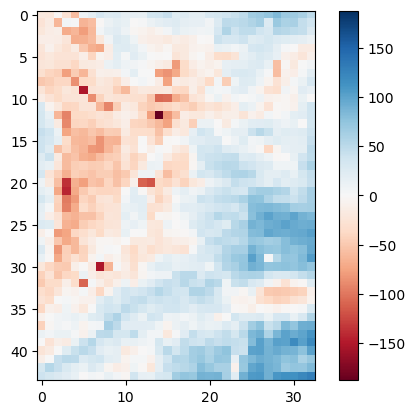

In [25]:
map_bias(y_target, y_pred)

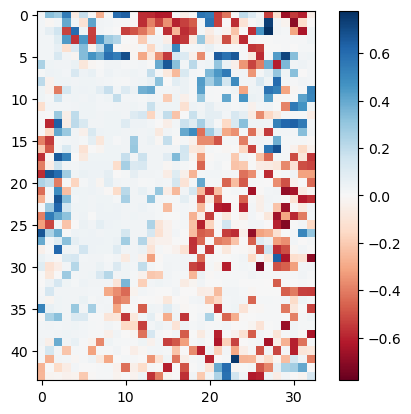

In [26]:
map_pearson(y_target, y_pred)

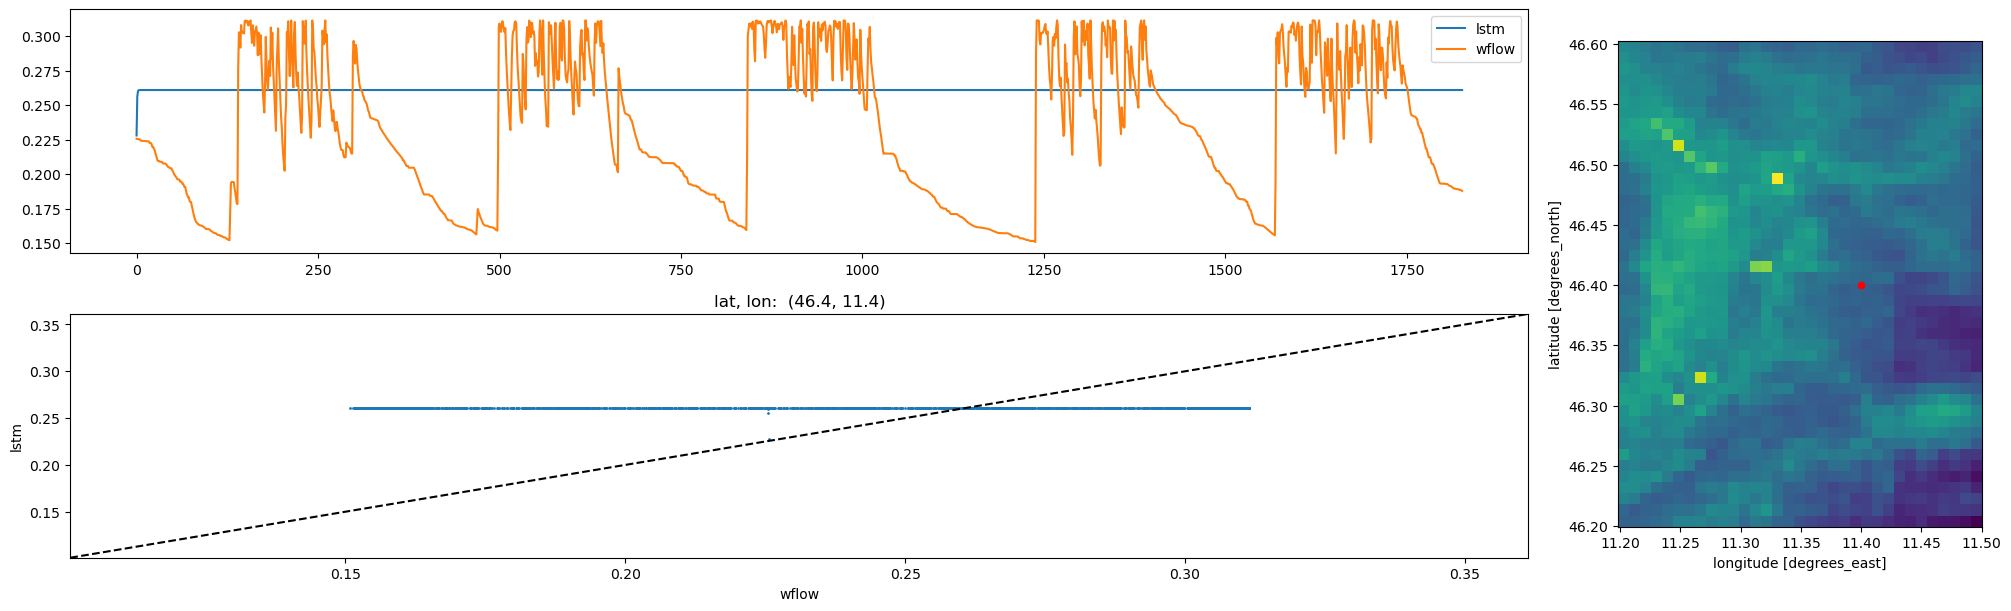

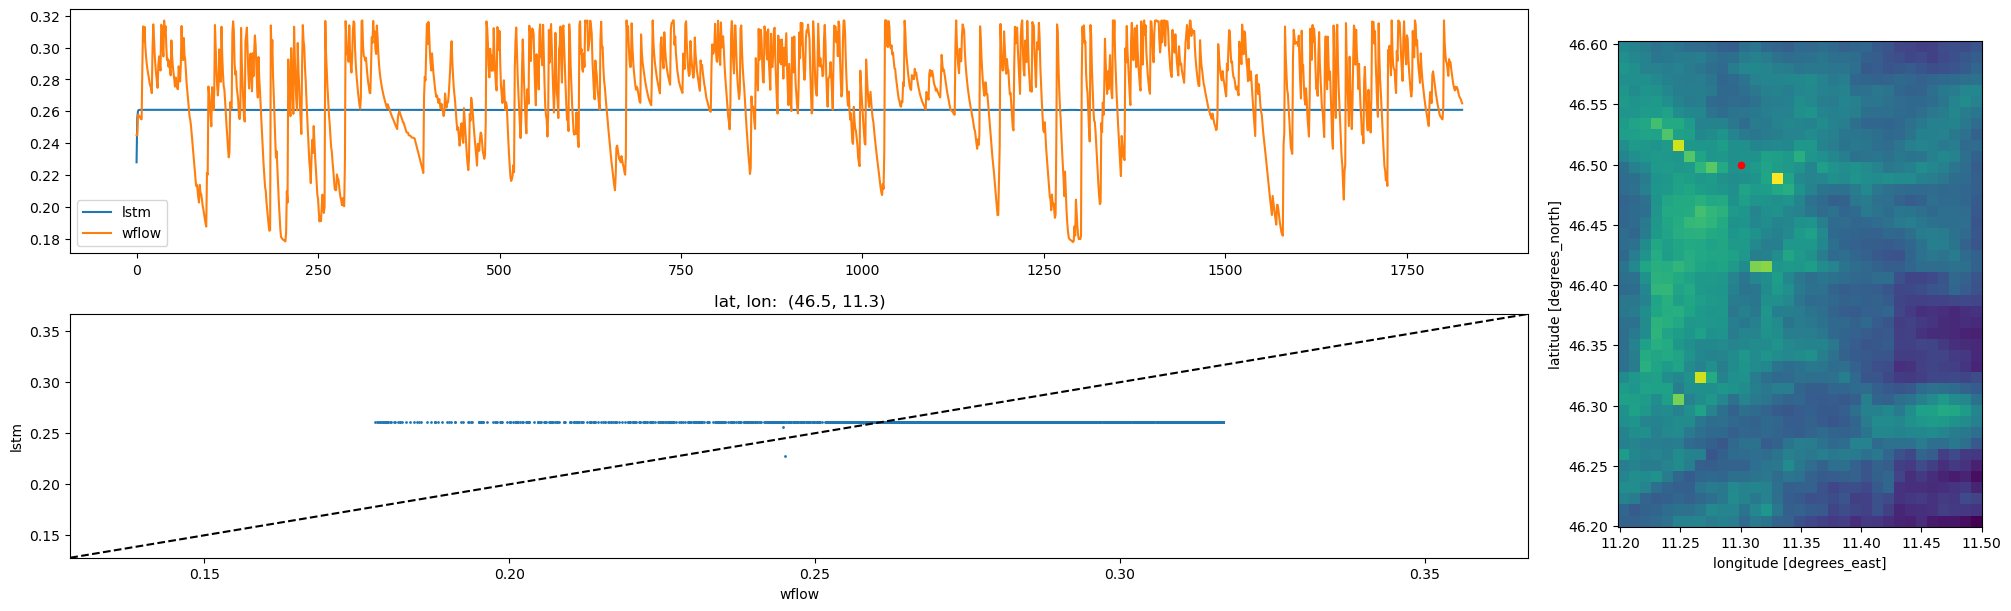

In [29]:
ts_compare(y_target, y_pred, lat = [46.4, 46.5], lon = [11.4, 11.3])

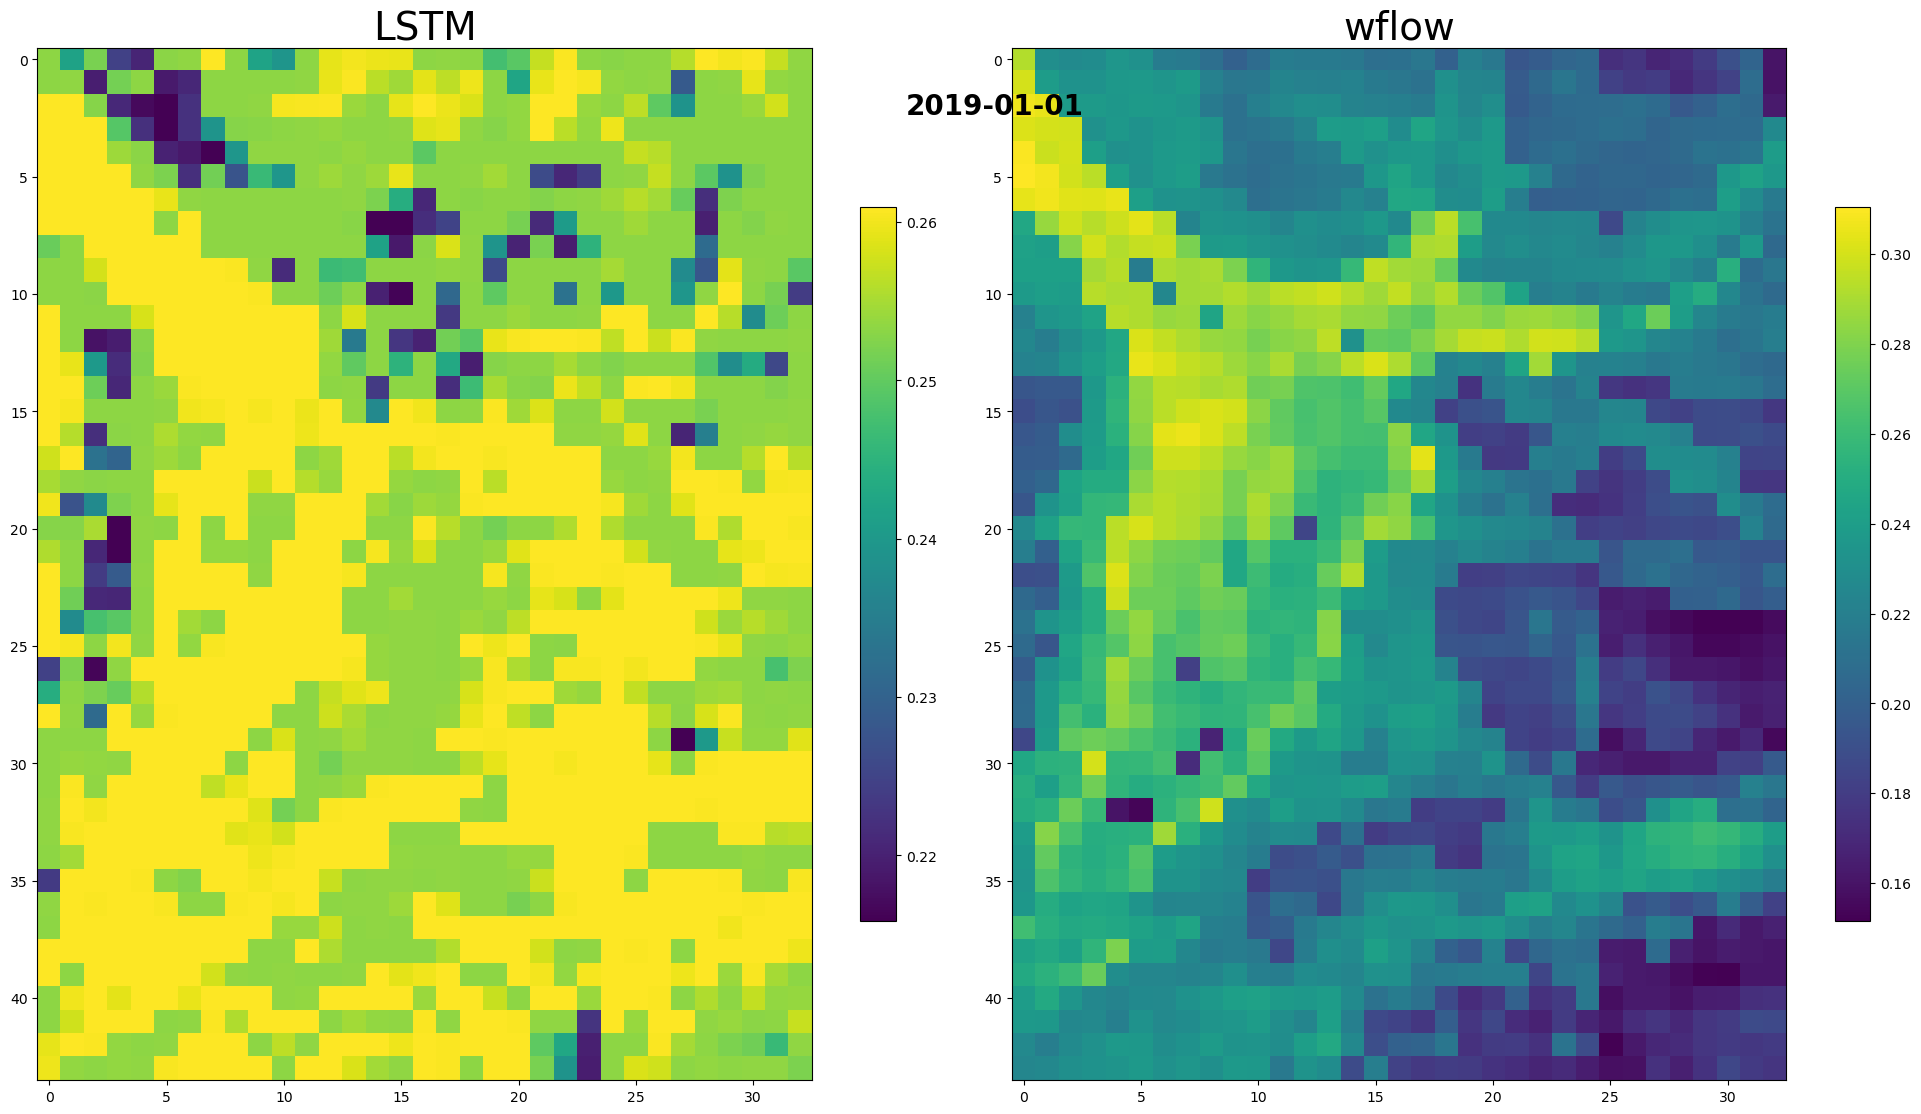

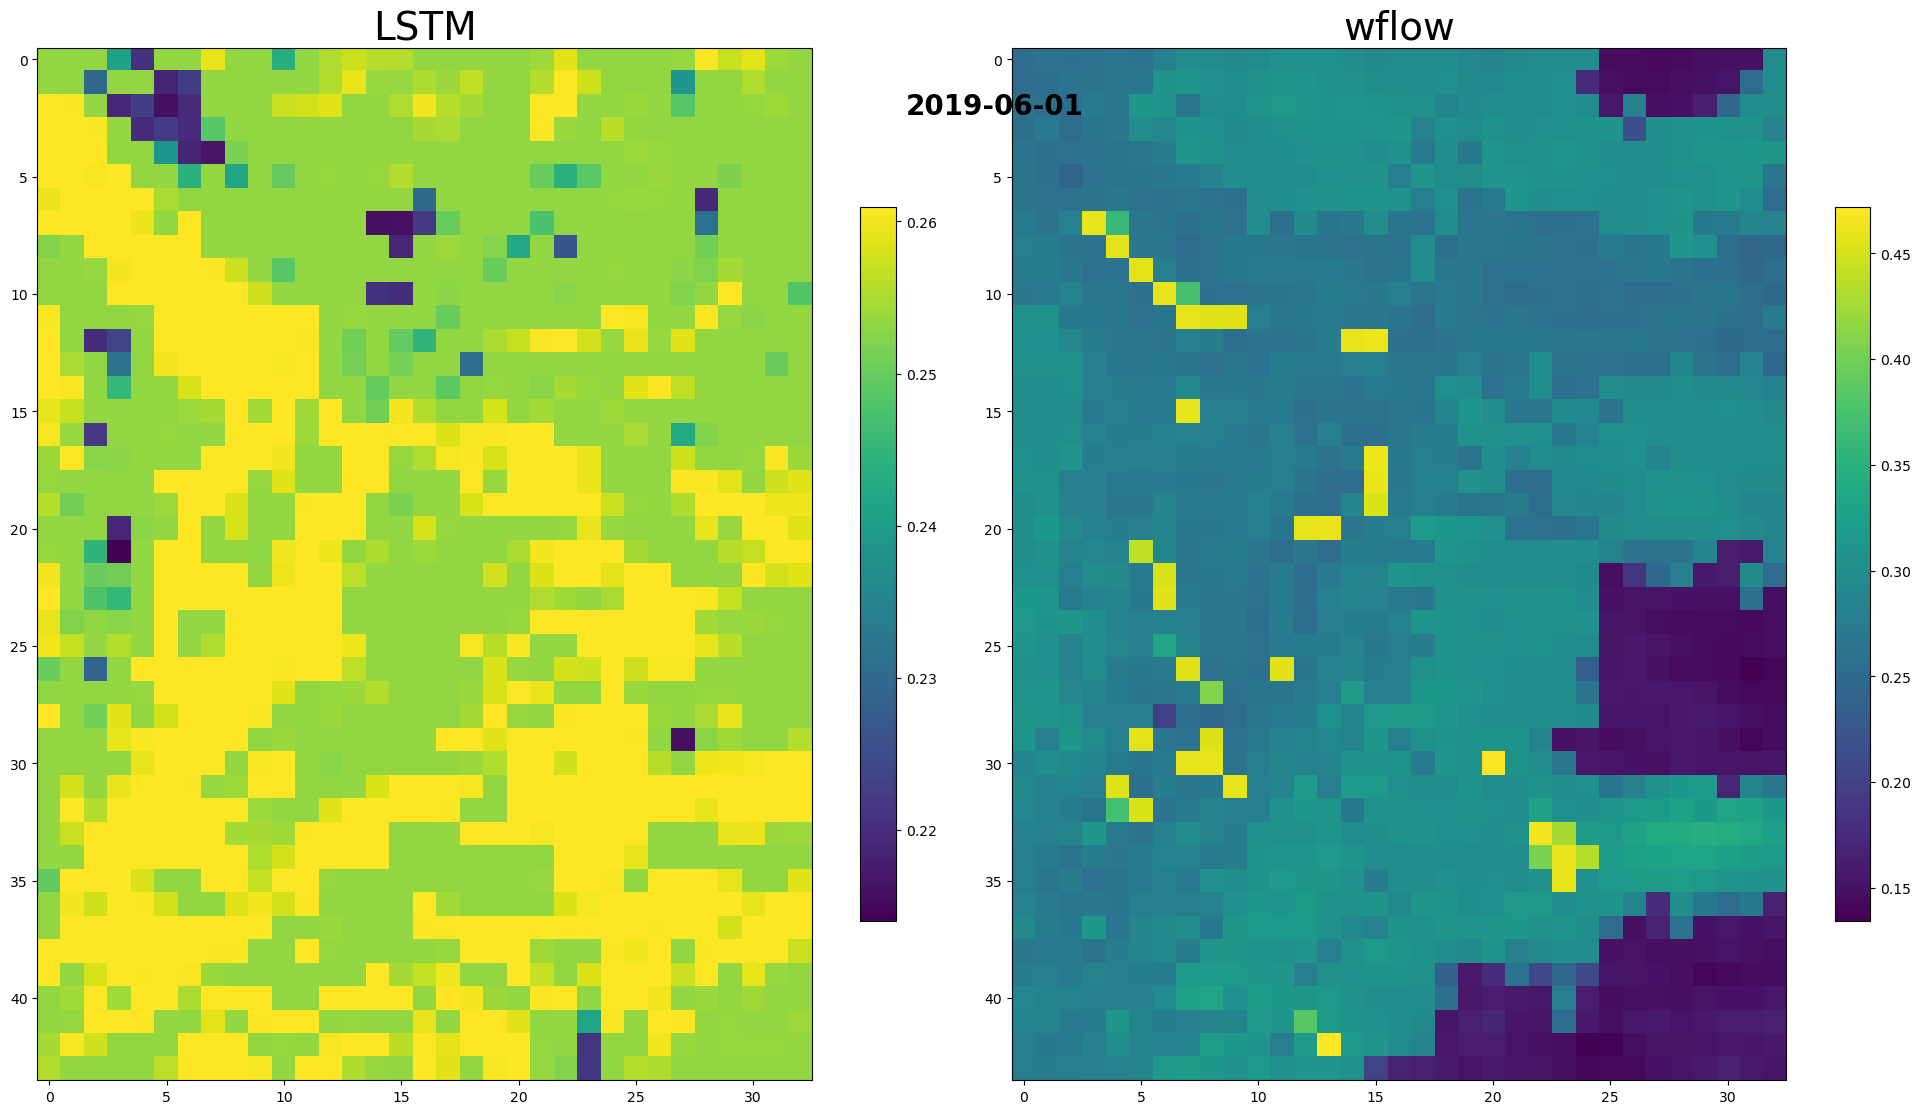

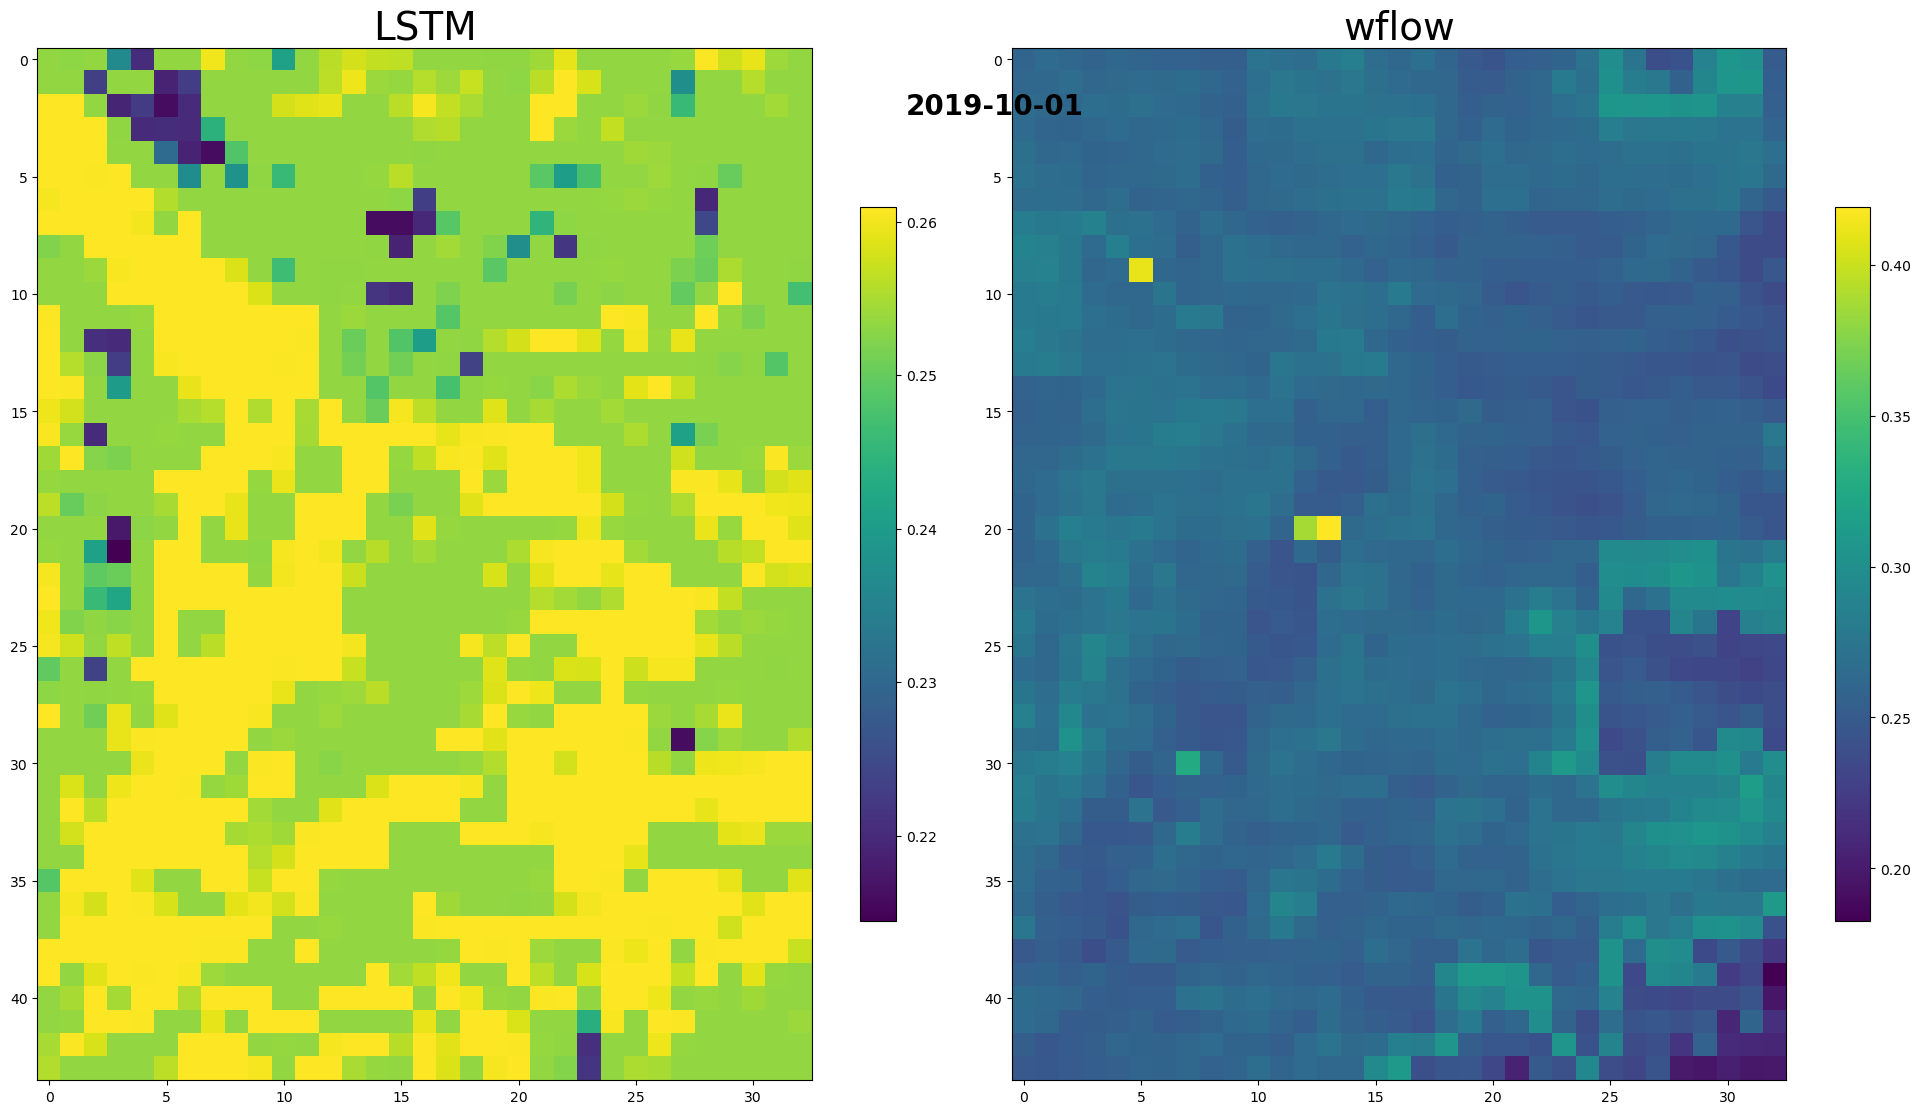

In [28]:
map_at_timesteps(y_target, y_pred, dates=["2019-01-01", "2019-06-01","2019-10-01"])